<a id="im"></a>
# <center>IMPORTING LIBRARIES</center> 

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix , classification_report 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')


<a id="hp"></a>
# <center>HYPERPARAMETRERS AND DIRECTORIES</center>

In [43]:
train_dir = "/kaggle/input/guava-disease-dataset/Guava Dataset (Original Image)"

SEED = 12
IMG_HEIGHT = 512
IMG_WIDTH = 512
BATCH_SIZE =12
EPOCHS = 20
#FINE_TUNING_EPOCHS = 20
LR = 0.01
CLASS_LABELS  =  os.listdir("/kaggle/input/guava-disease-dataset/Guava Dataset (Original Image)")
NUM_CLASSES = len(CLASS_LABELS)
EARLY_STOPPING_CRITERIA=3


CONFIG = dict (
    SEED = 12,
    IMG_HEIGHT = 512,
    IMG_WIDTH = 512,
    BATCH_SIZE =12,
    EPOCHS = 20,
    #FINE_TUNING_EPOCHS = 20,
    LR = 0.01,
    CLASS_LABELS  =  os.listdir("/kaggle/input/guava-disease-dataset/Guava Dataset (Original Image)"),
    NUM_CLASSES = len(CLASS_LABELS),
    EARLY_STOPPING_CRITERIA=3,
)    

<a id="data"></a>
# <center> DATA LOADING AND PRE-PROCESSING</center>

In [44]:
train_datagen = ImageDataGenerator(
                                   rescale = 1./255,
                                   validation_split = 0.2,
                                  )
valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2,   
                                 )

train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    subset = "training",
                                                    seed = SEED
                                                   )

valid_generator = valid_datagen.flow_from_directory(directory = train_dir,
                                                         target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                         batch_size = BATCH_SIZE,
                                                         shuffle  = False , 
                                                         color_mode = "rgb",
                                                         class_mode = "categorical",
                                                         subset = "validation",
                                                         seed = SEED
                                                        )


Found 354 images belonging to 4 classes.
Found 86 images belonging to 4 classes.


## Visualising Datset Images

In [ ]:
def display_one_image(image, title, subplot, color):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16)
    
def display_nine_images(images, titles, title_colors=None):
    subplot = 331
    plt.figure(figsize=(13,13))
    for i in range(4):
        color = 'black' if title_colors is None else title_colors[i]
        display_one_image(images[i], titles[i], 331+i, color)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

def image_title(label, prediction):
  # Both prediction (probabilities) and label (one-hot) are arrays with one item per class.
    class_idx = np.argmax(label, axis=-1)
    prediction_idx = np.argmax(prediction, axis=-1)
    if class_idx == prediction_idx:
        return f'{CLASS_LABELS[prediction_idx]} [correct]', 'black'
    else:
        return f'{CLASS_LABELS[prediction_idx]} [incorrect, should be {CLASS_LABELS[class_idx]}]', 'red'

def get_titles(images, labels, model):
    predictions = model.predict(images)
    titles, colors = [], []
    for label, prediction in zip(classes, predictions):
        title, color = image_title(label, prediction)
        titles.append(title)
        colors.append(color)
    return titles, colors


images, classes = next(train_generator)
class_idxs = np.argmax(classes, axis=-1) 
labels = [CLASS_LABELS[idx] for idx in class_idxs]
display_nine_images(images, labels)

## Data distribution (count) among differnt classes

In [ ]:
fig = px.bar(x = CLASS_LABELS,
             y = [list(train_generator.classes).count(i) for i in np.unique(train_generator.classes)] , 
             color = np.unique(train_generator.classes) ,
             color_continuous_scale="Emrld") 
fig.update_xaxes(title="Fruit Images")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Train Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

<a id="model"></a>
# <center> DenseNet201 Transfer Learning  </center>

In [ ]:
def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.DenseNet201(input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),
                                               include_top=False,
                                               weights="imagenet")(inputs)
    
    return feature_extractor

def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x= tf.keras.layers.BatchNormalization()(x)
    x= tf.keras.layers.Dense(512, activation=tf.nn.silu, 
                             kernel_regularizer = tf.keras.regularizers.l2(1e-5))(x)
    x= tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="classification")(x)
    
    return x

def final_model(inputs):
    densenet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(densenet_feature_extractor)
    
    return classification_output

def define_compile_model():
    
    inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT ,IMG_WIDTH,3))
    classification_output = final_model(inputs) 
    model = tf.keras.Model(inputs=inputs, outputs = classification_output)
     
    model.compile(optimizer=tf.keras.optimizers.SGD(LR), 
                loss='categorical_crossentropy',
                metrics = ['accuracy'])
  
    return model

## Summary of model

In [48]:
model = define_compile_model()
clear_output()

model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
densenet201 (Functional)     (None, 16, 16, 1920)      18321984  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1920)              0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 1920)              7680      
_________________________________________________________________
dense_4 (Dense)              (None, 512)               983552    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
classification (Dense)       (None, 4)                 2052

<a id="train"></a>
# <center> Training</center> 

In [49]:
earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                         patience=EARLY_STOPPING_CRITERIA,
                                                         verbose= 1 ,
                                                         restore_best_weights=True
                                                        )

history = model.fit(x = train_generator,
                    epochs = EPOCHS,
                    validation_data = valid_generator , 
#                     callbacks= [earlyStoppingCallback]
                   )


history = pd.DataFrame(history.history)

Epoch 1/20
30/30 [==============================] - 38s 754ms/step - loss: 0.4525 - accuracy: 0.8333 - val_loss: 0.9053 - val_accuracy: 0.5698
Epoch 2/20
30/30 [==============================] - 19s 620ms/step - loss: 0.1536 - accuracy: 0.9633 - val_loss: 0.7688 - val_accuracy: 0.6163
Epoch 3/20
30/30 [==============================] - 19s 622ms/step - loss: 0.0358 - accuracy: 1.0000 - val_loss: 0.6301 - val_accuracy: 0.6977
Epoch 4/20
30/30 [==============================] - 19s 623ms/step - loss: 0.0322 - accuracy: 0.9972 - val_loss: 0.4876 - val_accuracy: 0.7907
Epoch 5/20
30/30 [==============================] - 19s 624ms/step - loss: 0.0303 - accuracy: 0.9944 - val_loss: 0.4433 - val_accuracy: 0.8023
Epoch 6/20
30/30 [==============================] - 19s 644ms/step - loss: 0.0349 - accuracy: 0.9944 - val_loss: 0.4093 - val_accuracy: 0.8140
Epoch 7/20
30/30 [==============================] - 19s 633ms/step - loss: 0.0372 - accuracy: 0.9944 - val_loss: 0.3621 - val_accuracy: 0.8488

## Training plots

In [50]:
preds = model.predict(valid_generator)
y_preds = np.argmax(preds , axis = 1 )
y_test = np.array(valid_generator.labels)
def multiclass_roc_auc_score_wb(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    return roc_auc_score(y_test, y_pred, average=average)

auc = multiclass_roc_auc_score_wb(y_test , preds  , average = "micro")

## saving results

<a id="vis"></a>
# <center> Visualizing Results </center> 

## Model Evaluation and Confusion Matrix

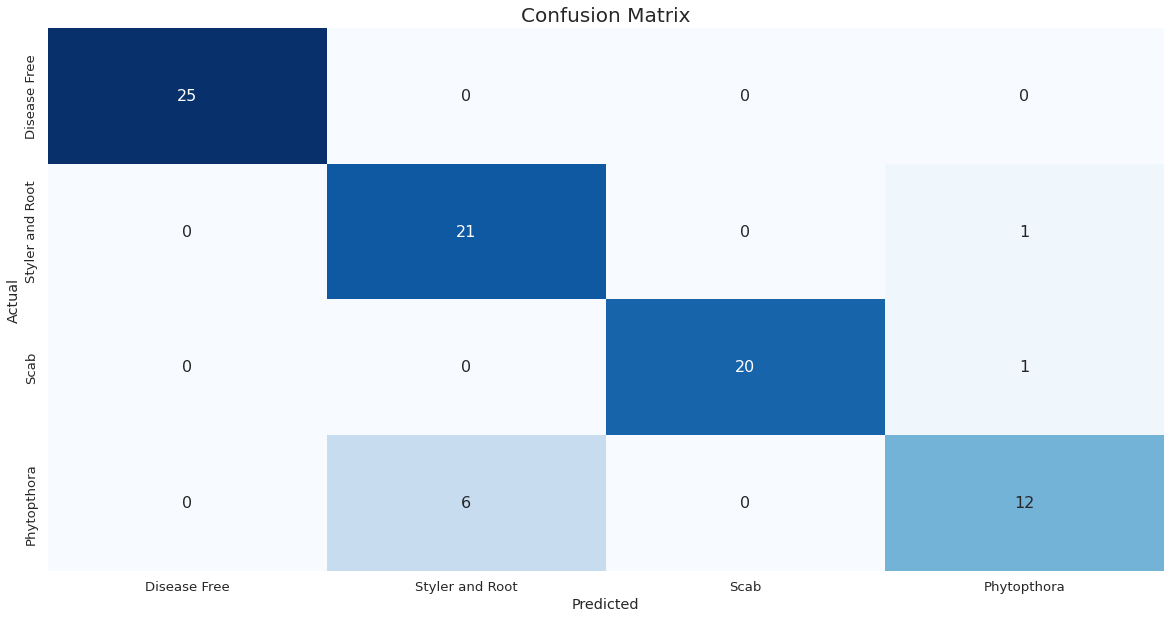

In [51]:
cm_data = confusion_matrix(y_test , y_preds)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

## Classification Report 

In [52]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       0.78      0.95      0.86        22
           2       1.00      0.95      0.98        21
           3       0.86      0.67      0.75        18

    accuracy                           0.91        86
   macro avg       0.91      0.89      0.90        86
weighted avg       0.91      0.91      0.91        86



## Multiclass AUC Curve

ROC AUC score: 0.9881918153957094


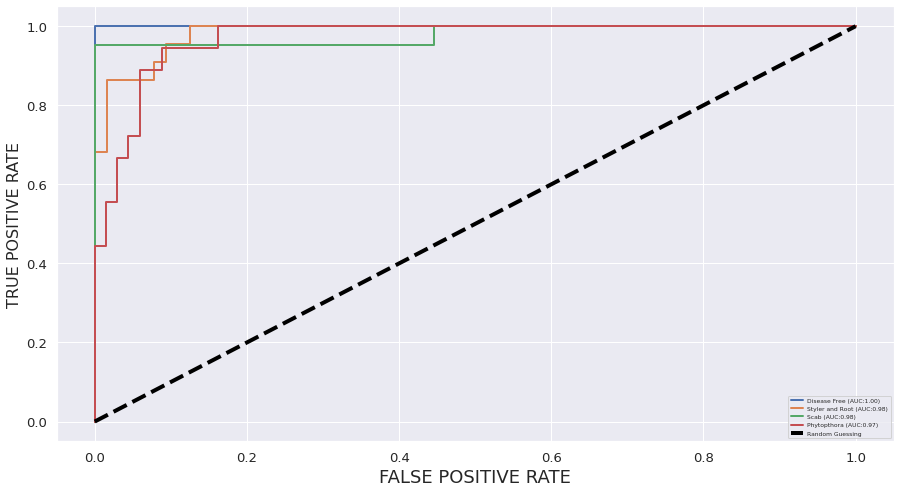

In [53]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

fig, c_ax = plt.subplots(1,1, figsize = (15,8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test , preds  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 6)
plt.show()

<a id="im"></a>
# <center>Custom Model</center> 


In [54]:
def custom_model(inputs):
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax', name='custom_output')(x)

    return outputs

def final_model(inputs):
    custom_output = custom_model(inputs)
    return custom_output


In [55]:
def define_compile_model():
    inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    custom_output = final_model(inputs)
    
    custom_model = tf.keras.Model(inputs=inputs, outputs=custom_output)

    custom_model.compile(optimizer=tf.keras.optimizers.SGD(LR),
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

    return custom_model

<a id="train"></a>
# <center> Training</center> 

In [ ]:
# Define and compile the custom model
custom_model = define_compile_model()

# Training
earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                         patience=EARLY_STOPPING_CRITERIA,
                                                         verbose=1,
                                                         restore_best_weights=True)

history = custom_model.fit(x=train_generator,
                           epochs=EPOCHS,
                           validation_data=valid_generator,
#                            callbacks=[earlyStoppingCallback]
                          )

# Evaluate the custom model
preds = custom_model.predict(valid_generator)
y_preds = np.argmax(preds, axis=1)
y_test = np.array(valid_generator.labels)


Epoch 1/20
30/30 [==============================] - 14s 473ms/step - loss: 1.4194 - accuracy: 0.3814 - val_loss: 1.3036 - val_accuracy: 0.4302
Epoch 2/20
30/30 [==============================] - 13s 453ms/step - loss: 1.2255 - accuracy: 0.4266 - val_loss: 1.2406 - val_accuracy: 0.5233
Epoch 3/20
30/30 [==============================] - 14s 457ms/step - loss: 1.1775 - accuracy: 0.4407 - val_loss: 1.1031 - val_accuracy: 0.5349
Epoch 4/20
30/30 [==============================] - 13s 432ms/step - loss: 1.0924 - accuracy: 0.5367 - val_loss: 0.9275 - val_accuracy: 0.6628
Epoch 5/20
30/30 [==============================] - 14s 465ms/step - loss: 1.2407 - accuracy: 0.4972 - val_loss: 1.3470 - val_accuracy: 0.4884
Epoch 6/20
30/30 [==============================] - 13s 437ms/step - loss: 1.0358 - accuracy: 0.5311 - val_loss: 1.2753 - val_accuracy: 0.3837
Epoch 7/20
30/30 [==============================] - 13s 449ms/step - loss: 1.1992 - accuracy: 0.5847 - val_loss: 1.2668 - val_accuracy: 0.3372

<a id="vis custom"></a>
# <center> Visualizing Results </center> 

## Model Evaluation and Confusion Matrix

In [ ]:
cm_data = confusion_matrix(y_test , y_preds)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')
# Save the confusion matrix heatmap as an image
plt.savefig('custom_confusion_matrix.png')
plt.show()

## Classification Report 

In [ ]:
print(classification_report(y_test, y_preds))

## Multiclass AUC Curve

In [ ]:
fig, c_ax = plt.subplots(1,1, figsize = (15,8))
auc = multiclass_roc_auc_score_wb(y_test , preds  , average = "micro")
print('ROC AUC score:', multiclass_roc_auc_score(y_test , preds  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 6)
# plt.savefig('custom_AUC.png')
plt.show()